In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 107.1 MB/s eta 0:00:00


Epoch 1/30
58/58 - 37s - 636ms/step - accuracy: 0.5465 - loss: 1.4886 - val_accuracy: 0.8786 - val_loss: 1.5240
Epoch 2/30
58/58 - 2s - 33ms/step - accuracy: 0.7020 - loss: 1.1234 - val_accuracy: 0.8597 - val_loss: 1.3107
Epoch 3/30
58/58 - 2s - 33ms/step - accuracy: 0.7051 - loss: 1.0415 - val_accuracy: 0.7098 - val_loss: 1.3898
Epoch 4/30
58/58 - 2s - 33ms/step - accuracy: 0.7244 - loss: 0.9585 - val_accuracy: 0.8812 - val_loss: 1.4530
Epoch 5/30
58/58 - 3s - 48ms/step - accuracy: 0.7383 - loss: 0.9582 - val_accuracy: 0.7330 - val_loss: 1.1818
Epoch 6/30
58/58 - 2s - 34ms/step - accuracy: 0.7368 - loss: 0.9123 - val_accuracy: 0.5963 - val_loss: 1.0985
Epoch 7/30
58/58 - 2s - 43ms/step - accuracy: 0.7531 - loss: 0.8847 - val_accuracy: 0.3437 - val_loss: 2.0297
Epoch 8/30
58/58 - 2s - 33ms/step - accuracy: 0.7560 - loss: 0.8593 - val_accuracy: 0.7770 - val_loss: 0.9757
Epoch 9/30
58/58 - 2s - 33ms/step - accuracy: 0.7702 - loss: 0.7984 - val_accuracy: 0.8744 - val_loss: 0.9271
Epoch 10

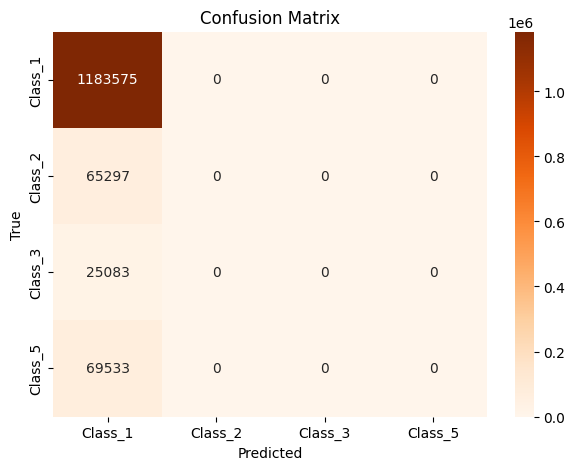

Classification Report (Focused):
              precision    recall  f1-score   support

     Class_1       0.88      1.00      0.94   1183575
     Class_2       0.00      0.00      0.00     65297
     Class_3       0.00      0.00      0.00     25083
     Class_5       0.00      0.00      0.00     69533

    accuracy                           0.88   1343488
   macro avg       0.22      0.25      0.23   1343488
weighted avg       0.78      0.88      0.83   1343488

Class_1 IoU: 0.881
Class_2 IoU: 0.000
Class_3 IoU: 0.000
Class_5 IoU: 0.000
Mean IoU: 0.220


In [3]:
import numpy as np
import rasterio
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
import seaborn as sns

PATCH_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 30
CLASS_MAP = {1: 0.3, 2: 1, 3: 2, 5: 3}  # New class indices
N_CLASSES = len(CLASS_MAP)

# --- Load Input Raster and Label ---
def load_stack(path):
    with rasterio.open(path) as src:
        X = src.read().astype(np.float32)
        X = np.transpose(X, (1, 2, 0))
    return X

def load_label(path):
    with rasterio.open(path) as src:
        y = src.read(1).astype(np.uint8)
    return y

X = load_stack('/content/drive/MyDrive/EarthEngine/stacked_input.tif')
y = load_label('/content/drive/MyDrive/EarthEngine/ForestFireRisk_2016_resampled.tif')

# --- Handle NaNs ---
X = np.nan_to_num(X, nan=np.nanmean(X))

# --- Normalize ---
X_min = np.nanmin(X, axis=(0, 1))
X_max = np.nanmax(X, axis=(0, 1))
X = (X - X_min) / (X_max - X_min + 1e-8)

# --- Patchify ---
def patchify_all(X, y, patch_size):
    X_patches, y_patches = [], []
    for i in range(0, X.shape[0] - patch_size + 1, patch_size):
        for j in range(0, X.shape[1] - patch_size + 1, patch_size):
            yp = y[i:i+patch_size, j:j+patch_size]
            if np.any(np.isin(yp, list(CLASS_MAP.keys()))):
                X_patches.append(X[i:i+patch_size, j:j+patch_size, :])
                y_mapped = np.full_like(yp, fill_value=255)
                for old, new in CLASS_MAP.items():
                    y_mapped[yp == old] = new
                y_mapped[y_mapped == 255] = 0  # Default to class 0 if unmapped
                y_patches.append(y_mapped)
    return np.array(X_patches), np.array(y_patches)

X_patches, y_patches = patchify_all(X, y, PATCH_SIZE)

# --- Oversample rare classes ---
def oversample(X, y, class_factors):
    X_os, y_os = [], []
    for cls, mult in class_factors.items():
        idx = [i for i in range(len(y)) if np.any(y[i] == cls)]
        for _ in range(mult):
            X_os.extend(X[idx])
            y_os.extend(y[idx])
    return np.array(X_os), np.array(y_os)

class_factors = {1: 3, 2: 5, 3: 8}
X_os, y_os = oversample(X_patches, y_patches, class_factors)

X_all = np.concatenate([X_patches, X_os])
y_all = np.concatenate([y_patches, y_os])

# --- One-hot encode ---
y_all_cat = tf.keras.utils.to_categorical(y_all, num_classes=N_CLASSES)

# --- Train/Val split ---
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all_cat, test_size=0.15, random_state=42)

# --- U-Net Model ---
def improved_unet(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    def conv_block(x, filters):
        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return tf.keras.layers.ReLU()(x)

    c1 = conv_block(inputs, 32)
    p1 = tf.keras.layers.MaxPooling2D()(c1)
    p1 = tf.keras.layers.Dropout(0.2)(p1)

    c2 = conv_block(p1, 64)
    p2 = tf.keras.layers.MaxPooling2D()(c2)
    p2 = tf.keras.layers.Dropout(0.3)(p2)

    c3 = conv_block(p2, 128)
    u2 = tf.keras.layers.UpSampling2D()(c3)
    u2 = tf.keras.layers.Concatenate()([u2, c2])

    c4 = conv_block(u2, 64)
    u1 = tf.keras.layers.UpSampling2D()(c4)
    u1 = tf.keras.layers.Concatenate()([u1, c1])

    c5 = conv_block(u1, 32)
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return tf.keras.Model(inputs, outputs)

model = improved_unet((PATCH_SIZE, PATCH_SIZE, X.shape[2]), N_CLASSES)

# --- Loss Function ---
class_weights = np.array([1, 2, 5, 10], dtype=np.float32)

def weighted_cce(y_true, y_pred):
    weights = tf.reduce_sum(class_weights * y_true, axis=-1)
    unweighted_losses = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.reduce_mean(unweighted_losses * weights)

model.compile(optimizer='adam', loss=weighted_cce, metrics=['accuracy'])

# --- Training ---
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# --- Evaluation ---
y_val_int = np.argmax(y_val, axis=-1)
y_pred_probs = model.predict(X_val)
y_pred_int = np.argmax(y_pred_probs, axis=-1)

# --- Optional Filtering ---
def filter_rare_blobs(pred_map, rare_classes=[2, 3], min_blob=5, max_blob=500):
    output = pred_map.copy()
    for rc in rare_classes:
        mask = (pred_map == rc)
        labeled, n_blobs = ndi.label(mask)
        sizes = np.bincount(labeled.ravel())
        remove = (sizes < min_blob) | (sizes > max_blob)
        for i in np.where(remove)[0]:
            output[labeled == i] = 0
    return output

filtered_preds = np.stack([filter_rare_blobs(p) for p in y_pred_int])

# --- Metrics ---
y_val_flat = y_val_int.flatten()
y_pred_flat = filtered_preds.flatten()

labels = list(range(N_CLASSES))
class_names = ['Class_1', 'Class_2', 'Class_3', 'Class_5']
cm = confusion_matrix(y_val_flat, y_pred_flat, labels=labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report (Focused):")
print(classification_report(y_val_flat, y_pred_flat, labels=labels, target_names=class_names, zero_division=0))

ious = jaccard_score(y_val_flat, y_pred_flat, labels=labels, average=None, zero_division=0)
for i, iou in enumerate(ious):
    print(f"{class_names[i]} IoU: {iou:.3f}")
print(f"Mean IoU: {np.mean(ious):.3f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step


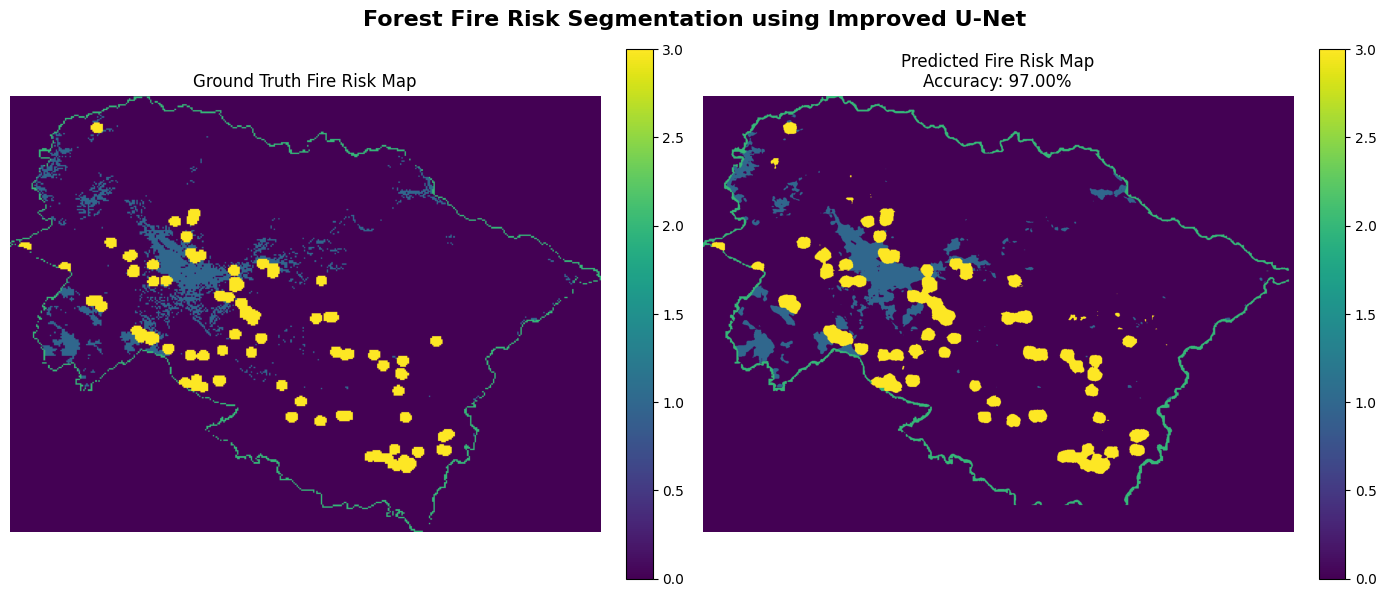

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- 1. Patchify full image (no label filtering) ---
def patchify_full(X, patch_size):
    patches = []
    coords = []
    for i in range(0, X.shape[0] - patch_size + 1, patch_size):
        for j in range(0, X.shape[1] - patch_size + 1, patch_size):
            patch = X[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            coords.append((i, j))
    return np.array(patches), coords

X_full_patches, coords = patchify_full(X, PATCH_SIZE)

# --- 2. Predict on all patches ---
pred_probs = model.predict(X_full_patches, batch_size=BATCH_SIZE, verbose=1)
pred_classes = np.argmax(pred_probs, axis=-1)  # shape: (num_patches, patch_size, patch_size)

# --- 3. Reconstruct full predicted map from patches ---
h, w = X.shape[:2]
full_pred_map = np.zeros((h, w), dtype=np.uint8)
for idx, (i, j) in enumerate(coords):
    full_pred_map[i:i+PATCH_SIZE, j:j+PATCH_SIZE] = pred_classes[idx]

# --- 4. Calculate Accuracy ---
# Make sure y is remapped using CLASS_MAP if necessary
# Example: y_remapped = np.vectorize(CLASS_MAP.get)(y)
y_remapped = np.full_like(y, fill_value=0)
for old, new in CLASS_MAP.items():
    y_remapped[y == old] = int(new)

# Resize y_remapped if needed to match shape
y_true_crop = y_remapped[:h, :w]
accuracy = accuracy_score(y_true_crop.flatten(), full_pred_map.flatten())

# --- 5. Visualize side-by-side ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.suptitle("Forest Fire Risk Segmentation using Improved U-Net", fontsize=16, fontweight='bold')

im0 = axs[0].imshow(y_true_crop, vmin=0, vmax=N_CLASSES-1, cmap='viridis')
axs[0].set_title("Ground Truth Fire Risk Map")
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(full_pred_map, vmin=0, vmax=N_CLASSES-1, cmap='viridis')
axs[1].set_title(f"Predicted Fire Risk Map\nAccuracy: {accuracy*100:.2f}%")
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import imageio

# --- 1. Extract fire seed pixels ---
def extract_fire_seeds(pred_map, risk_classes=(2, 3)):
    return np.isin(pred_map, risk_classes).astype(np.uint8)

# --- 2. Fire spread for one time step ---
def spread_fire_one_step(fire_map, spread_prob=0.05):
    padded = np.pad(fire_map, 1, mode='constant', constant_values=0)
    new_fire = np.zeros_like(fire_map)

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            neighbors = padded[1 + dx : 1 + dx + fire_map.shape[0], 1 + dy : 1 + dy + fire_map.shape[1]]
            spread = (neighbors == 1) & (fire_map == 0) & (np.random.rand(*fire_map.shape) < spread_prob)
            new_fire = np.logical_or(new_fire, spread)

    return np.logical_or(fire_map, new_fire).astype(np.uint8)

# --- 3. Run simulation for defined hours ---
def run_fire_simulation(pred_map, steps=[1, 2, 3, 6, 12], spread_prob=0.05, risk_classes=(2, 3), save_gif=False, gif_name='fire_spread.gif'):
    fire_seed_mask = extract_fire_seeds(pred_map, risk_classes)
    fire_map = fire_seed_mask.copy().astype(np.uint8)
    fire_maps = {0: fire_map.copy()}
    frames = [fire_map.copy()]
    max_step = max(steps)

    for t in range(1, max_step + 1):
        fire_map = spread_fire_one_step(fire_map, spread_prob)
        if t in steps:
            fire_maps[t] = fire_map.copy()
        frames.append(fire_map.copy())

    if save_gif:
        imgs = [(frame * 255).astype(np.uint8) for frame in frames]
        imageio.mimsave(gif_name, imgs, duration=0.3)

    return fire_maps

# --- 4. Plot fire maps ---
def plot_fire_maps(fire_maps, steps=[0, 1, 2, 3, 6, 12]):
    n = len(steps)
    plt.figure(figsize=(3 * n, 4))
    for i, step in enumerate(steps):
        plt.subplot(1, n, i + 1)
        plt.imshow(fire_maps[step], cmap='hot', interpolation='nearest')
        plt.title(f"Step {step}h")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- 5. Save each fire map as GeoTIFF ---
def save_fire_maps_as_geotiff(fire_maps, steps, reference_tif_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    with rasterio.open(reference_tif_path) as src:
        meta = src.meta.copy()
        meta.update({
            'count': 1,
            'dtype': 'uint8',
            'driver': 'GTiff'
        })

        for step in steps:
            out_path = os.path.join(output_dir, f'fire_spread_{step}h.tif')
            with rasterio.open(out_path, 'w', **meta) as dst:
                dst.write(fire_maps[step], 1)
            print(f"✅ Saved: {out_path}")


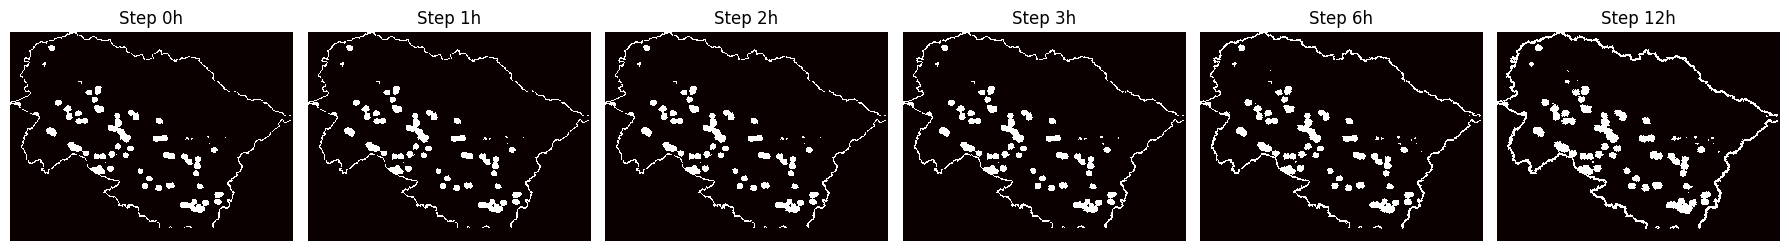

✅ Saved: /content/drive/MyDrive/EarthEngine/fire_spread_outputs/fire_spread_1h.tif
✅ Saved: /content/drive/MyDrive/EarthEngine/fire_spread_outputs/fire_spread_2h.tif
✅ Saved: /content/drive/MyDrive/EarthEngine/fire_spread_outputs/fire_spread_3h.tif
✅ Saved: /content/drive/MyDrive/EarthEngine/fire_spread_outputs/fire_spread_6h.tif
✅ Saved: /content/drive/MyDrive/EarthEngine/fire_spread_outputs/fire_spread_12h.tif


In [10]:
# Run this after your full_pred_map is generated from U-Net
steps = [1, 2, 3, 6, 12]
reference_tif = '/content/drive/MyDrive/EarthEngine/ForestFireRisk_2016_resampled.tif'
output_dir = '/content/drive/MyDrive/EarthEngine/fire_spread_outputs'

# Simulate fire spread and create GIF
fire_maps = run_fire_simulation(full_pred_map, steps=steps, spread_prob=0.05, save_gif=True, gif_name='fire_spread.gif')

# Visualize spread
plot_fire_maps(fire_maps, steps=[0] + steps)

# Save GeoTIFFs
save_fire_maps_as_geotiff(fire_maps, steps, reference_tif_path=reference_tif, output_dir=output_dir)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# --- 1. Fire Simulation ---
def extract_fire_seeds(pred_map, risk_classes=(2, 3)):
    return np.isin(pred_map, risk_classes).astype(np.uint8)

def spread_fire_one_step(fire_map, spread_prob=0.03):
    padded = np.pad(fire_map, 1, mode='constant', constant_values=0)
    new_fire = np.zeros_like(fire_map)

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            neighbors = padded[1+dx:1+dx+fire_map.shape[0], 1+dy:1+dy+fire_map.shape[1]]
            spread = (neighbors == 1) & (fire_map == 0) & (np.random.rand(*fire_map.shape) < spread_prob)
            new_fire = np.logical_or(new_fire, spread)

    return np.logical_or(fire_map, new_fire).astype(np.uint8)

def simulate_fire_spread_steps(pred_map, steps=12, spread_prob=0.03, risk_classes=(2, 3)):
    fire_seed_mask = extract_fire_seeds(pred_map, risk_classes)
    fire_map = fire_seed_mask.copy()
    frames = [fire_map.copy()]
    for _ in range(steps):
        fire_map = spread_fire_one_step(fire_map, spread_prob)
        frames.append(fire_map.copy())
    return frames


/tmp/ipython-input-7-2244902764.py:16: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  HTML(ani.to_jshtml())


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


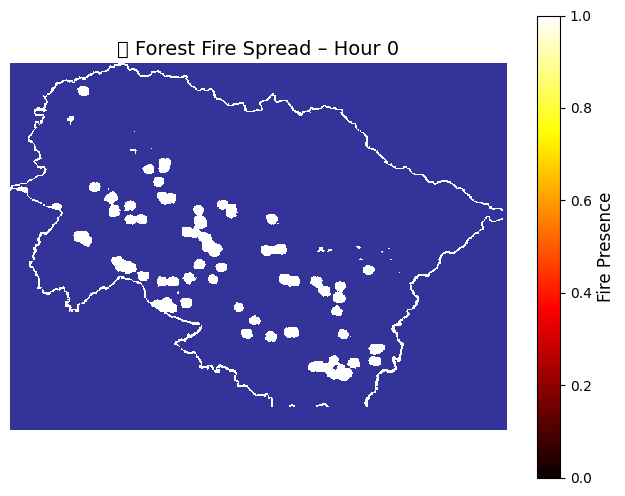

In [7]:
frames = simulate_fire_spread_steps(full_pred_map, steps=6)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(frames[0], cmap='hot', interpolation='nearest', vmin=0, vmax=1)
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Fire Presence', fontsize=12)

def update(frame_idx):
    ax.clear()
    im = ax.imshow(frames[frame_idx], cmap='terrain', interpolation='nearest', vmin=0, vmax=1)
    ax.set_title(f"🔥 Forest Fire Spread – Hour {frame_idx}", fontsize=14)
    ax.axis('off')
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=800, blit=False, repeat=False)
HTML(ani.to_jshtml())


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_fire_spread_with_background(fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12], title='Forest Fire Spread Map at 1/2/3/4/6/12 hours'):
    n = len(steps)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5))
    axs = axs.flatten()

    for i, step in enumerate(steps):
        ax = axs[i]

        # Background map
        if background_map.ndim == 2:
            ax.imshow(background_map, cmap='terrain')
        else:
            ax.imshow(background_map)  # RGB image

        # Fire overlay
        fire_overlay = np.ma.masked_where(fire_maps[step] == 0, fire_maps[step])
        cmap = mcolors.ListedColormap(['red'])
        ax.imshow(fire_overlay, cmap=cmap, alpha=0.6)

        ax.set_title(f"Hour-{step}", fontsize=14)
        ax.axis('off')

    # Hide extra subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


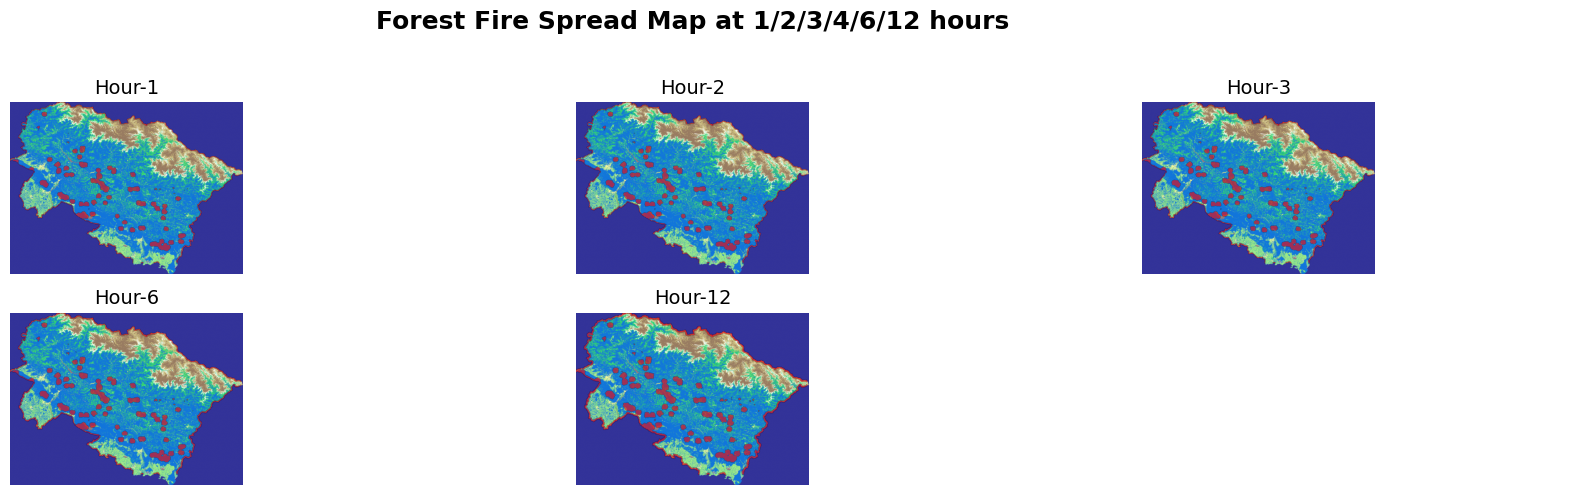

In [11]:
# Simulate fire maps (already done)
# fire_maps = run_fire_simulation(pred_map, steps=[1,2,3,6,12])

# Load LULC or terrain raster (grayscale or RGB)
with rasterio.open('/content/drive/MyDrive/EarthEngine/lulc_small_resampled.tif') as src:
    background_map = src.read(1)  # Use read([1,2,3]).transpose(1,2,0) for RGB

# Plot
available_steps = [s for s in [1, 2, 3, 4, 6, 12] if s in fire_maps]
plot_fire_spread_with_background(fire_maps, background_map, steps=available_steps)



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import imageio

# --- 1. Extract high-risk fire seed pixels ---
def extract_fire_seeds(pred_map, risk_classes=(2, 3)):
    return np.isin(pred_map, risk_classes).astype(np.uint8)

# --- 2. Fire spread for one time step ---
def spread_fire_one_step(fire_map, spread_prob=0.12):  # Increased probability
    padded = np.pad(fire_map, 1, mode='constant', constant_values=0)
    new_fire = np.zeros_like(fire_map)

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            neighbors = padded[1 + dx : 1 + dx + fire_map.shape[0], 1 + dy : 1 + dy + fire_map.shape[1]]
            spread = (neighbors == 1) & (fire_map == 0) & (np.random.rand(*fire_map.shape) < spread_prob)
            new_fire = np.logical_or(new_fire, spread)

    return np.logical_or(fire_map, new_fire).astype(np.uint8)

# --- 3. Run full simulation for selected time steps ---
def run_fire_simulation(pred_map, steps=[1, 2, 3, 4, 6, 12], spread_prob=0.12, risk_classes=(2, 3), save_gif=False, gif_name='fire_spread.gif'):
    fire_seed_mask = extract_fire_seeds(pred_map, risk_classes)
    fire_map = fire_seed_mask.copy().astype(np.uint8)
    fire_maps = {0: fire_map.copy()}
    frames = [fire_map.copy()]
    max_step = max(steps)

    for t in range(1, max_step + 1):
        fire_map = spread_fire_one_step(fire_map, spread_prob)
        if t in steps:
            fire_maps[t] = fire_map.copy()
        frames.append(fire_map.copy())

    if save_gif:
        imgs = [(frame * 255).astype(np.uint8) for frame in frames]
        imageio.mimsave(gif_name, imgs, duration=0.3)

    return fire_maps

# --- 4. Plot fire maps with title and consistent colorbar ---
def plot_fire_maps(fire_maps, steps=[1, 2, 3, 4, 6, 12], title='Forest Fire Spread Map at 1/2/3/4/6/12 hours'):
    n = len(steps)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, step in enumerate(steps):
        im = axs[i].imshow(fire_maps[step], cmap='Reds', interpolation='nearest', vmin=0, vmax=1)
        axs[i].set_title(f"Hour-{step}")
        axs[i].axis('off')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    fig.suptitle(title, fontsize=18, weight='bold')
    cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
    fig.colorbar(im, cax=cbar_ax, label='Fire Presence (0=No, 1=Yes)')
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

# --- 5. Save fire maps as GeoTIFFs ---
def save_fire_maps_as_geotiff(fire_maps, steps, reference_tif_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    with rasterio.open(reference_tif_path) as src:
        meta = src.meta.copy()
        meta.update({'count': 1, 'dtype': 'uint8', 'driver': 'GTiff'})
        for step in steps:
            out_path = os.path.join(output_dir, f'fire_spread_{step}h.tif')
            with rasterio.open(out_path, 'w', **meta) as dst:
                dst.write(fire_maps[step], 1)
            print(f"✅ Saved: {out_path}")


In [13]:
def plot_fire_spread_with_background(fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12], title='Forest Fire Spread Map at 1/2/3/4/6/12 hours'):
    n = len(steps)
    ncols = 3
    nrows = 2  # Since you want a space after 3 plots (e.g., 3 per row)

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, step in enumerate(steps):
        axs[i].imshow(background_map, cmap='terrain')
        axs[i].imshow(fire_maps[step], cmap='Reds', alpha=0.5)
        axs[i].set_title(f"Hour-{step}")
        axs[i].axis('off')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    fig.suptitle(title, fontsize=18, weight='bold')

    # Add vertical space between rows
    plt.subplots_adjust(hspace=0.3)  # You can adjust the value as needed

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


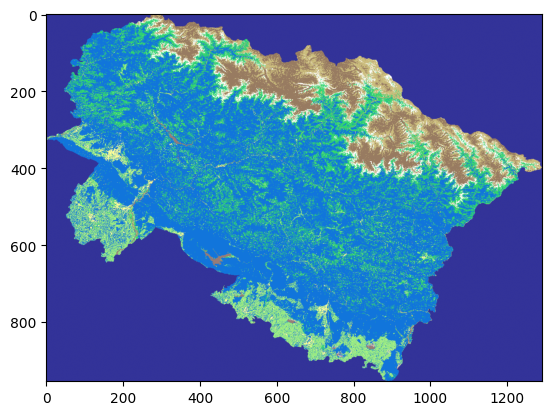

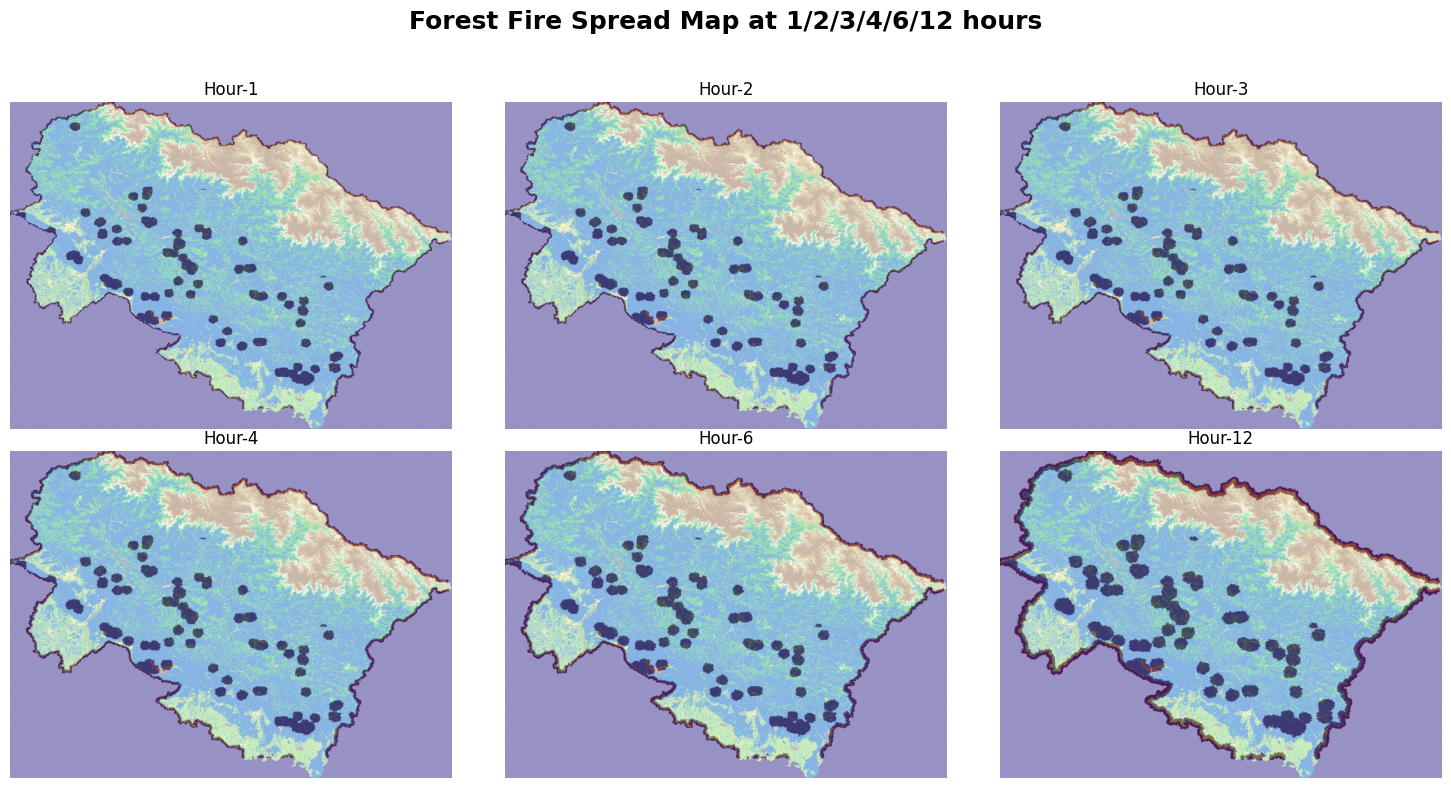

In [ ]:
# 1. Define pred_map from U-Net output
pred_map = full_pred_map  # or load it from a .npy or .tif if saved earlier

# Run simulation (make sure pred_map is defined)
fire_maps = run_fire_simulation(pred_map, steps=[1, 2, 3, 4, 6, 12], spread_prob=0.12)

# Load background map (e.g., LULC or DEM)
with rasterio.open('/content/drive/MyDrive/EarthEngine/lulc_small_resampled.tif') as src:
    background_map = src.read(1)
plt.imshow(background_map, cmap='terrain')


# Plot with overlay
available_steps = [s for s in [1, 2, 3, 4, 6, 12] if s in fire_maps]
plot_fire_spread_with_background(fire_maps, background_map, steps=available_steps)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os

def plot_pred_and_fire_spread(predicted_map_path, fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12], title='Fire Spread Simulation with Background'):
    # --- Load predicted fire risk map ---
    with rasterio.open(predicted_map_path) as src:
        predicted_map = src.read(1)

    n = len(steps)
    total_plots = n + 1  # 1 for predicted map
    ncols = 3
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axs = axs.flatten()

    # --- Plot Predicted Map on Top ---
    axs[0].imshow(predicted_map, cmap='viridis', vmin=0, vmax=3)
    axs[0].set_title("Predicted Fire Risk Map (U-Net Output)")
    axs[0].axis('off')

    # --- Plot Fire Spread Maps ---
    for i, step in enumerate(steps):
        idx = i + 1  # Shift by 1 due to predicted map at index 0
        axs[idx].imshow(background_map, cmap='terrain')
        axs[idx].imshow(fire_maps[step], cmap='Reds', alpha=0.5)
        axs[idx].set_title(f"Hour-{step}")
        axs[idx].axis('off')

    # --- Hide unused subplots ---
    for j in range(total_plots, len(axs)):
        axs[j].axis('off')

    fig.suptitle(title, fontsize=18, weight='bold')

    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_risk_and_spread_grid(predicted_map_path, fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12]):
    # ----- Load predicted risk map -----
    with rasterio.open(predicted_map_path) as src:
        risk_map = src.read(1)

    # ----- Create custom colormap for risk levels -----
    classes = ['Very Low', 'Low', 'Moderate', 'High']
    cmap_risk = ListedColormap(['lightgreen', 'yellowgreen', 'orange', 'red'])
    norm_risk = BoundaryNorm([0, 1, 2, 3, 4], cmap_risk.N)

    fig = plt.figure(figsize=(15, 14))
    gs = fig.add_gridspec(3, 3)

    # ---- Top image: Risk Map with legend ----
    ax1 = fig.add_subplot(gs[0, :])
    im = ax1.imshow(risk_map, cmap='cmap_risk', norm=norm_risk)
    ax1.set_title("🔥 Predicted Forest Fire Risk Map", fontsize=16, weight='bold')
    ax1.axis('off')

    # ---- Add custom colorbar legend ----
    cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.02)
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5])
    cbar.set_ticklabels(classes)
    cbar.set_label('Fire Risk Level')

    # ---- Spread maps below ----
    for idx, step in enumerate(steps):
        row = 1 + (idx // 3)
        col = idx % 3
        ax = fig.add_subplot(gs[row, col])
        ax.imshow(background_map, cmap='terrain')
        ax.imshow(fire_maps[step], cmap='Reds', alpha=0.5)
        ax.set_title(f"Hour-{step}")
        ax.axis('off')

    fig.suptitle("Prediction Map ➜ Fire Spread Maps", fontsize=18, weight='bold')
    plt.tight_layout(rect=[0, 1, 1, 0.95])
    plt.show()

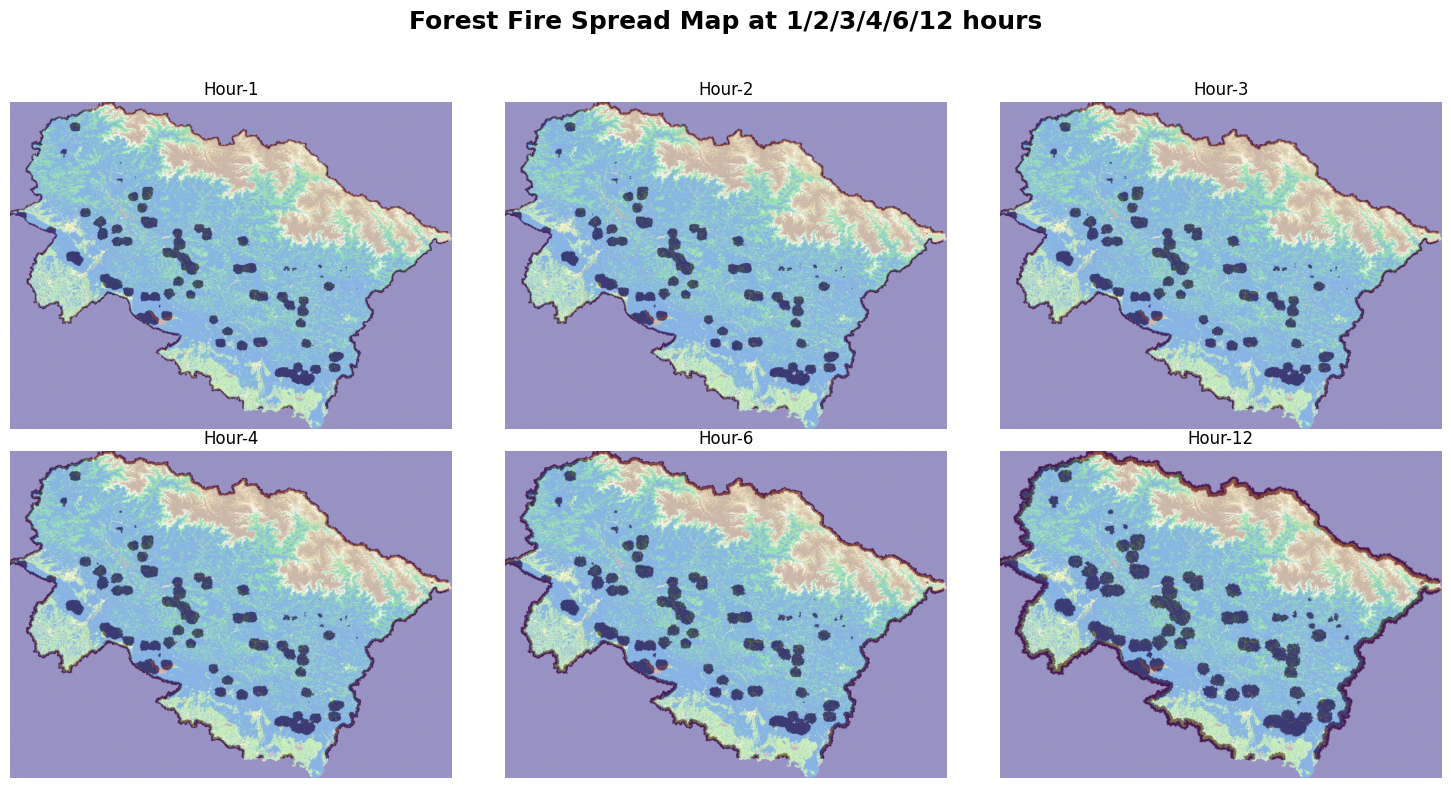

In [30]:
# 1. Define pred_map from U-Net output
pred_map = full_pred_map  # or load it from a .npy or .tif if saved earlier

# 2. Run fire simulation
fire_maps = run_fire_simulation(pred_map, steps=[1, 2, 3, 4, 6, 12], spread_prob=0.12)

# 3. Load background map
with rasterio.open('/content/drive/MyDrive/EarthEngine/lulc_small_resampled.tif') as src:
    background_map = src.read(1)

# 4. Plot overlay map
available_steps = [s for s in [1, 2, 3, 4, 6, 12] if s in fire_maps]
plot_fire_spread_with_background(fire_maps, background_map, steps=available_steps)

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_risk_and_spread_grid(pred_map, fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12]):
    # Define fire risk class colors (Low, Moderate, High)
    risk_colors = ['lightgray', 'yellow', 'red']
    risk_labels = ['Low', 'Moderate', 'High']
    cmap_risk = ListedColormap(risk_colors)
    norm_risk = BoundaryNorm([0, 1, 2, 3], len(risk_colors))

    ncols = 3
    nrows = (len(steps) + ncols - 1) // ncols
    total_rows = nrows + 1

    fig = plt.figure(figsize=(6 * ncols, 4.5 * total_rows))
    gs = GridSpec(total_rows, ncols, figure=fig)

    # --- Top: Predicted Fire Risk Map ---
    ax0 = fig.add_subplot(gs[0, :])
    ax0.imshow(background_map, cmap='terrain', alpha=1)
    im = ax0.imshow(pred_map, cmap=cmap_risk, norm=norm_risk, alpha=0.6)
    ax0.set_title("Predicted Fire Risk Map", fontsize=16, weight='bold')
    ax0.axis('off')

    # Colorbar
    cbar = fig.colorbar(im, ax=ax0, orientation='horizontal', fraction=0.046, pad=0.02)
    cbar.set_ticks([0.5, 1.5, 2.5])
    cbar.set_ticklabels(risk_labels)
    cbar.set_label("Fire Risk Level", fontsize=12)

    # --- Bottom: Fire Spread Maps ---
    for i, step in enumerate(steps):
        row = (i // ncols) + 1
        col = i % ncols
        ax = fig.add_subplot(gs[row, col])
        ax.imshow(background_map, cmap='terrain', alpha=1)
        ax.imshow(fire_maps[step], cmap='Reds', alpha=0.5)
        ax.set_title(f"Fire Spread at Hour {step}", fontsize=13)
        ax.axis('off')

    # Figure title
    fig.suptitle("Simulated Fire Spread: Hourly Evolution", fontsize=20, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


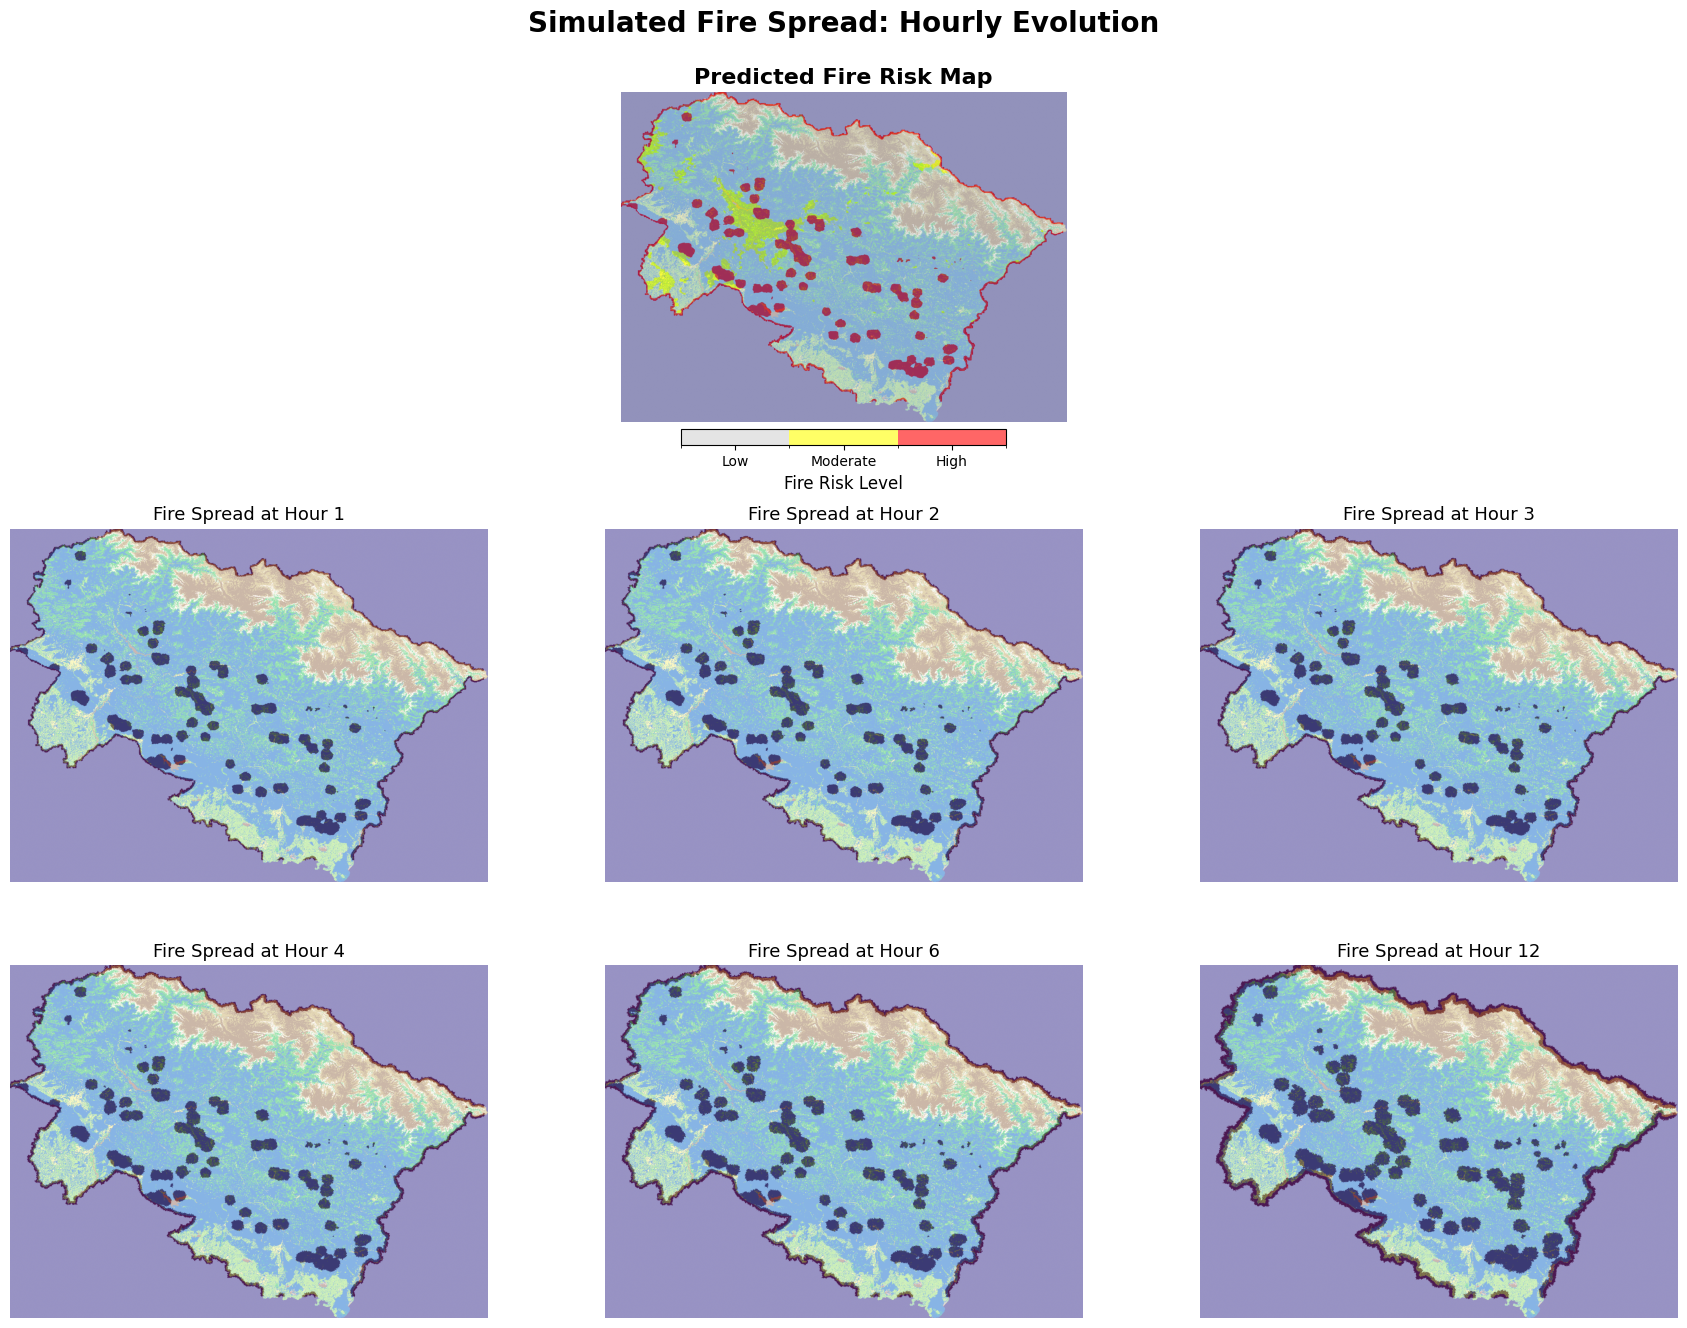

In [97]:
plot_risk_and_spread_grid(pred_map, fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12])


In [104]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_risk_and_spread_grid(pred_map, fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12]):
    # Fire risk class colors
    risk_colors = ['lightgray', 'yellow', 'red']
    risk_labels = ['Low', 'Moderate', 'High']
    cmap_risk = ListedColormap(risk_colors)
    norm_risk = BoundaryNorm([0, 1, 2, 3], len(risk_colors))

    # Transparent fire spread colormap: 0 → transparent, 1 → red
    fire_cmap = ListedColormap([(0, 0, 0, 0), (1, 0, 0, 1)])  # RGBA

    # Grid setup
    ncols = 3
    nrows = (len(steps) + ncols - 1) // ncols
    total_rows = nrows + 1  # +1 for top map

    fig = plt.figure(figsize=(6 * ncols, 4.5 * total_rows))
    gs = GridSpec(total_rows, ncols, figure=fig)

    # --- Top: Predicted Fire Risk Map ---
    ax0 = fig.add_subplot(gs[0, :])
    ax0.imshow(background_map, cmap='terrain', alpha=1)
    im = ax0.imshow(pred_map, cmap=cmap_risk, norm=norm_risk, alpha=0.6)
    ax0.set_title("Predicted Fire Risk Map", fontsize=16, weight='bold')
    ax0.axis('off')

    # Colorbar
    cbar = fig.colorbar(im, ax=ax0, orientation='horizontal', fraction=0.046, pad=0.02)
    cbar.set_ticks([0.5, 1.5, 2.5])
    cbar.set_ticklabels(risk_labels)
    cbar.set_label("Fire Risk Level", fontsize=12)

    # --- Bottom: Fire Spread Maps over LULC ---
    for i, step in enumerate(steps):
        row = (i // ncols) + 1
        col = i % ncols
        ax = fig.add_subplot(gs[row, col])
        ax.imshow(background_map, cmap='terrain', alpha=1)
        ax.imshow(fire_maps[step], cmap=fire_cmap, vmin=0, vmax=1)
        ax.set_title(f"Fire Spread at Hour {step}", fontsize=13)
        ax.axis('off')

    # Final layout and title
    fig.suptitle("Simulated Fire Spread: Hourly Evolution", fontsize=20, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


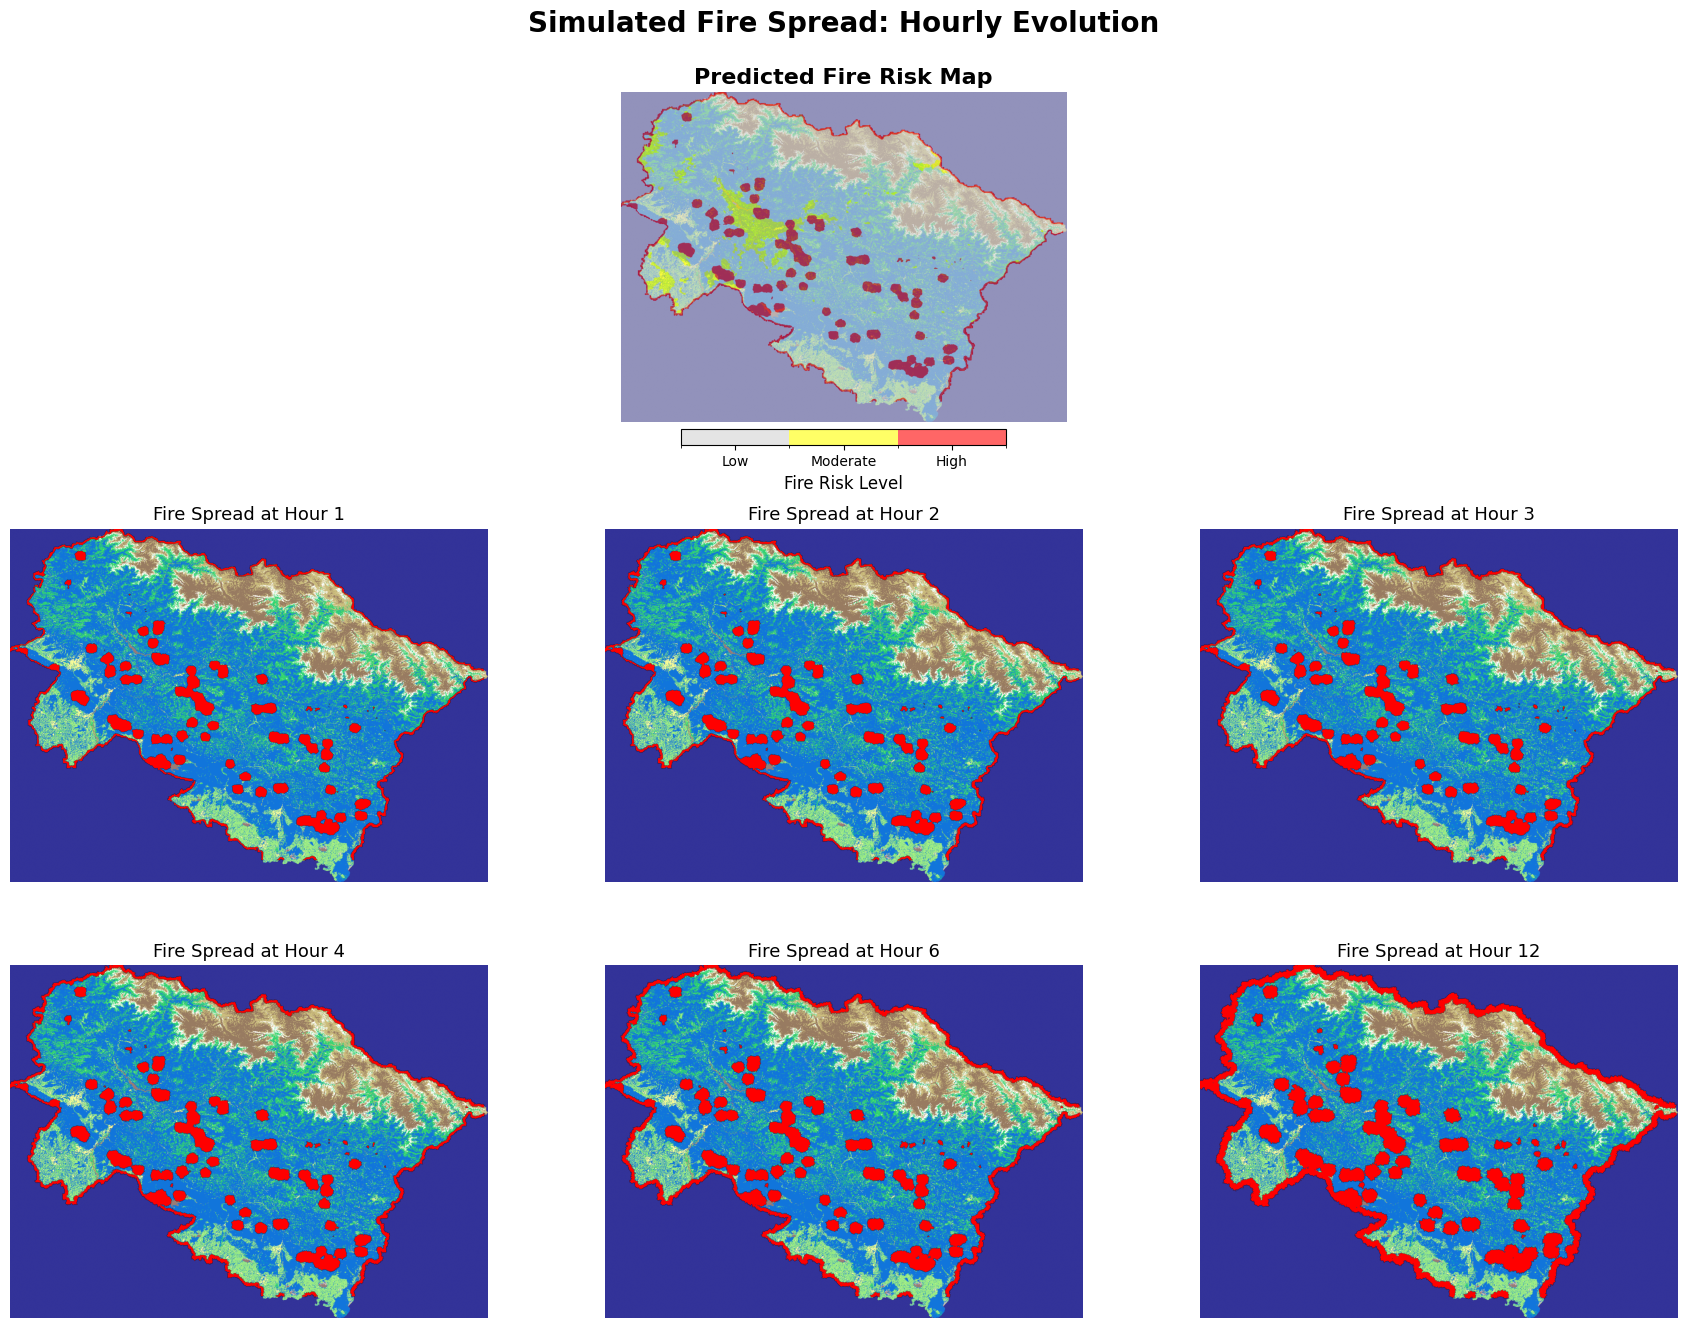

In [105]:
plot_risk_and_spread_grid(pred_map, fire_maps, background_map, steps=[1, 2, 3, 4, 6, 12])
